# Needed function and package 

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import re
import os
import sys
sys.path.append('../../pylib')
import cx_lib

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc


# Normalization

### Firstly, normalize the data. This part is finished with ```scripts/R/evaluation.R```, results are saved in ```data/original_data/hela```.

##  Statistical Comparisons

### Using PCA, chacking the batch clusters. The CycLoess, RT-Loess, RT-median and RT-VSN have closer cluster.

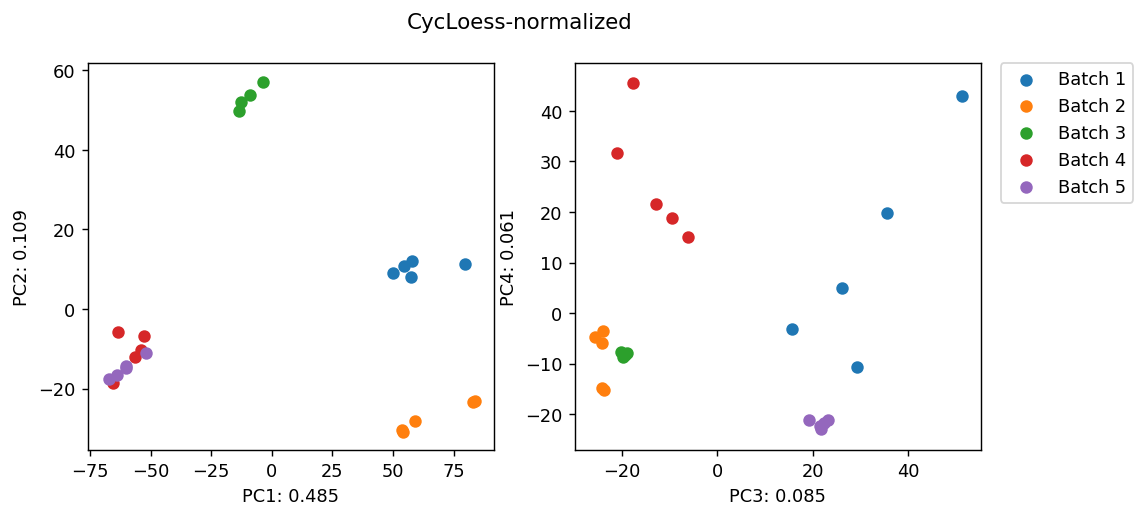

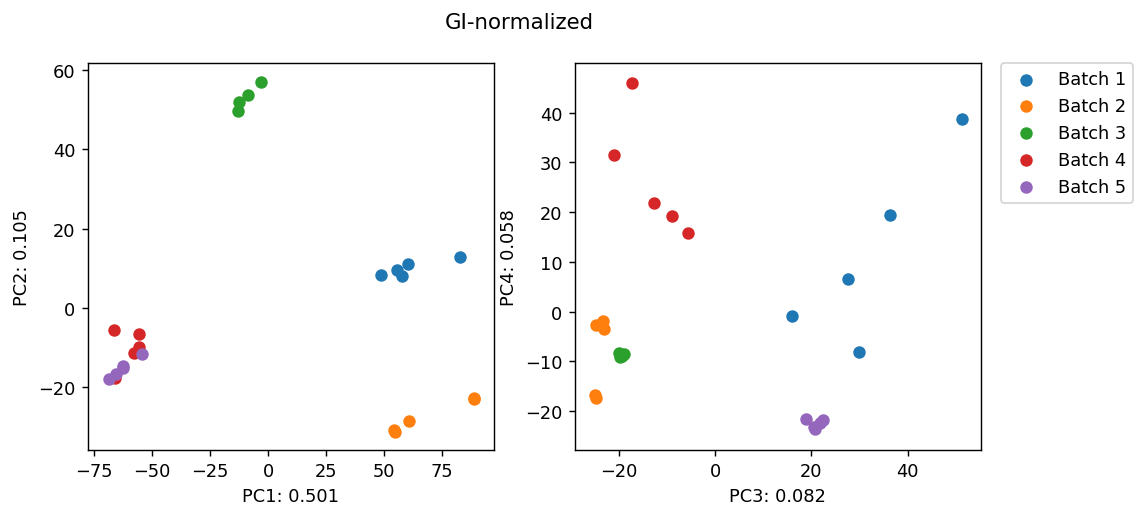

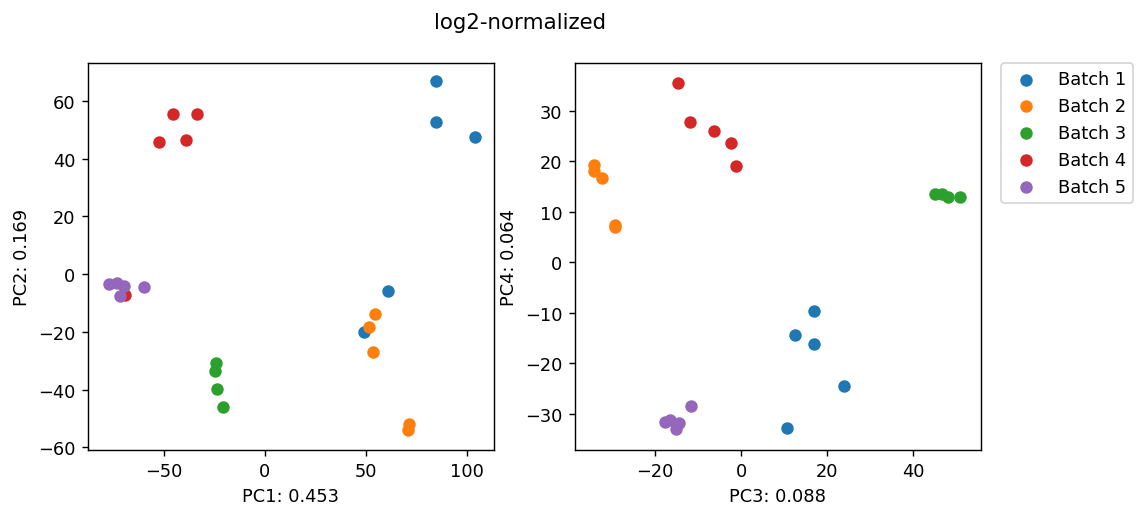

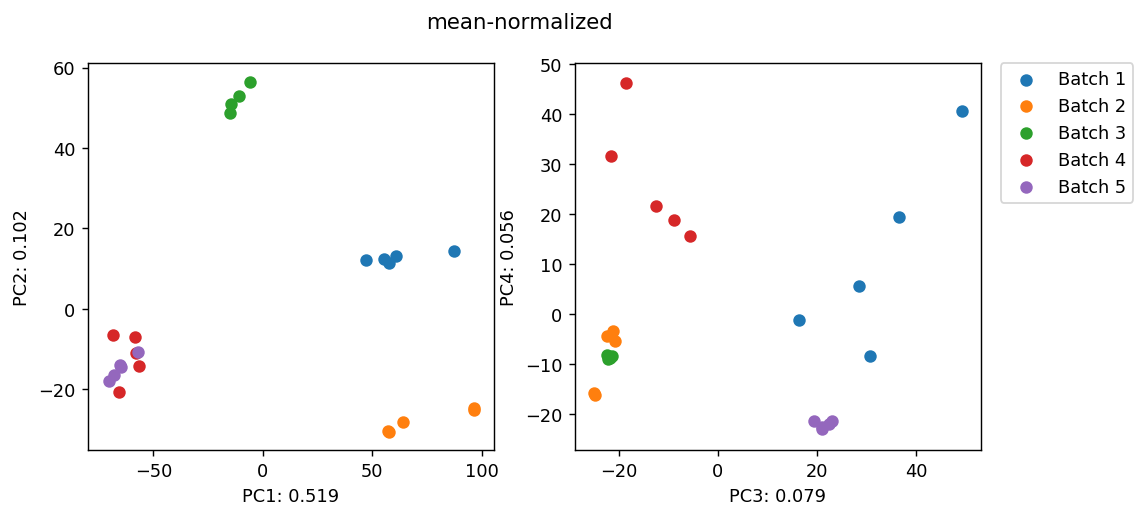

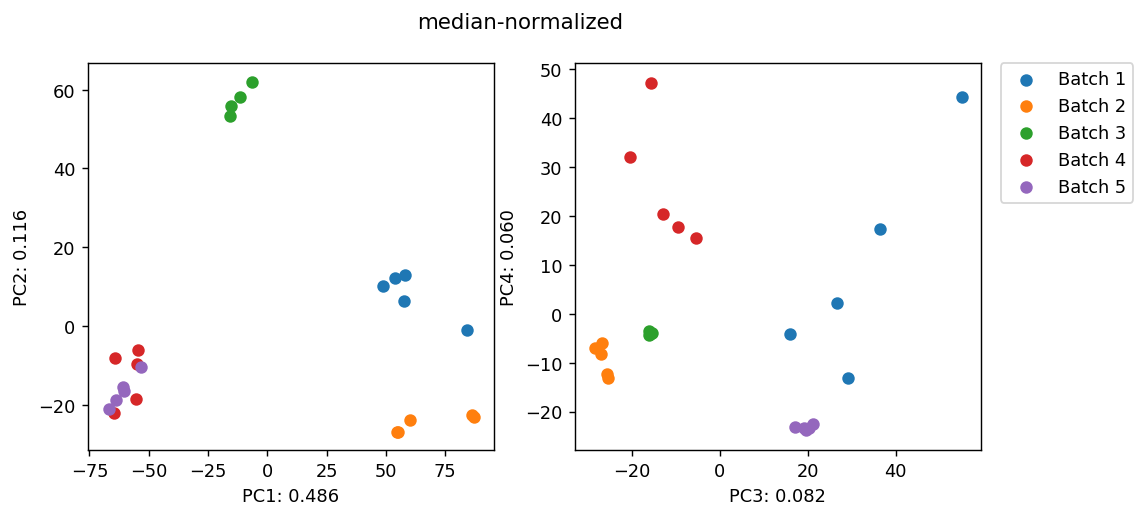

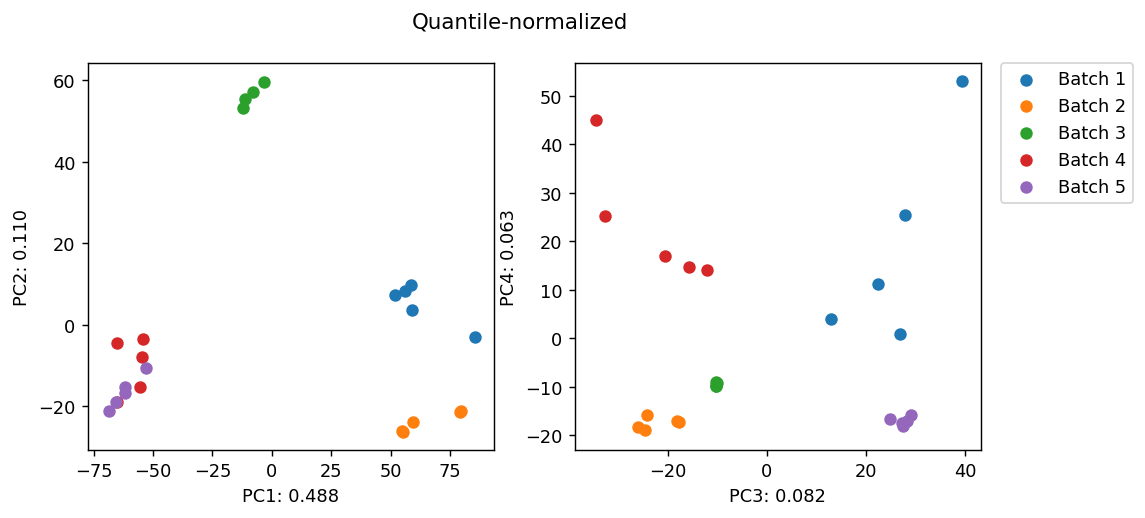

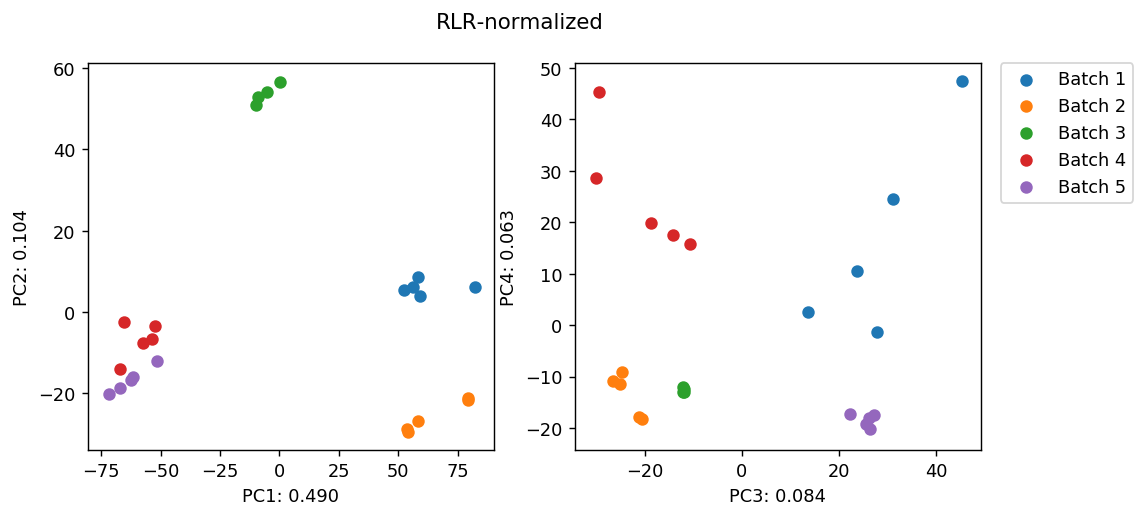

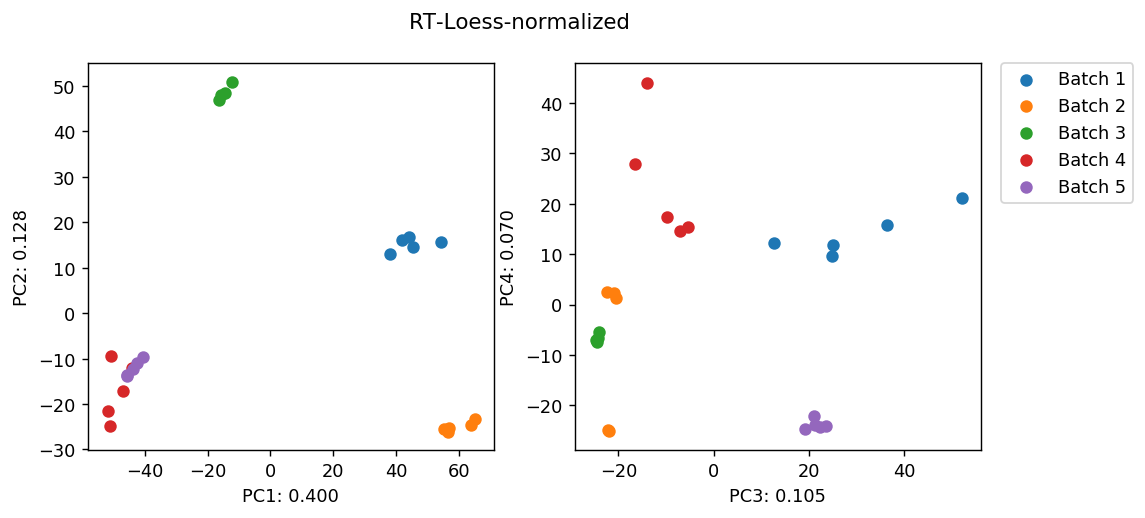

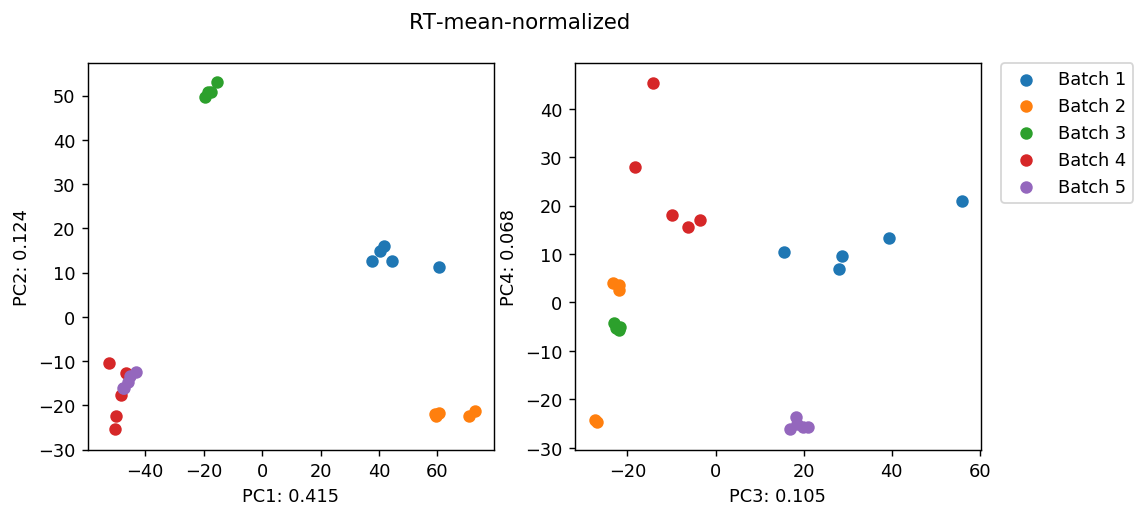

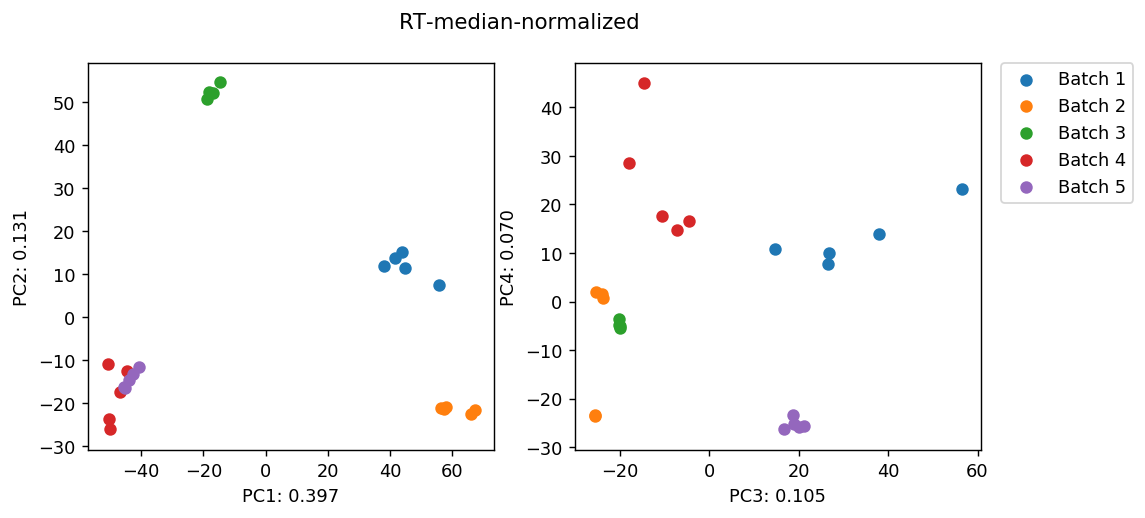

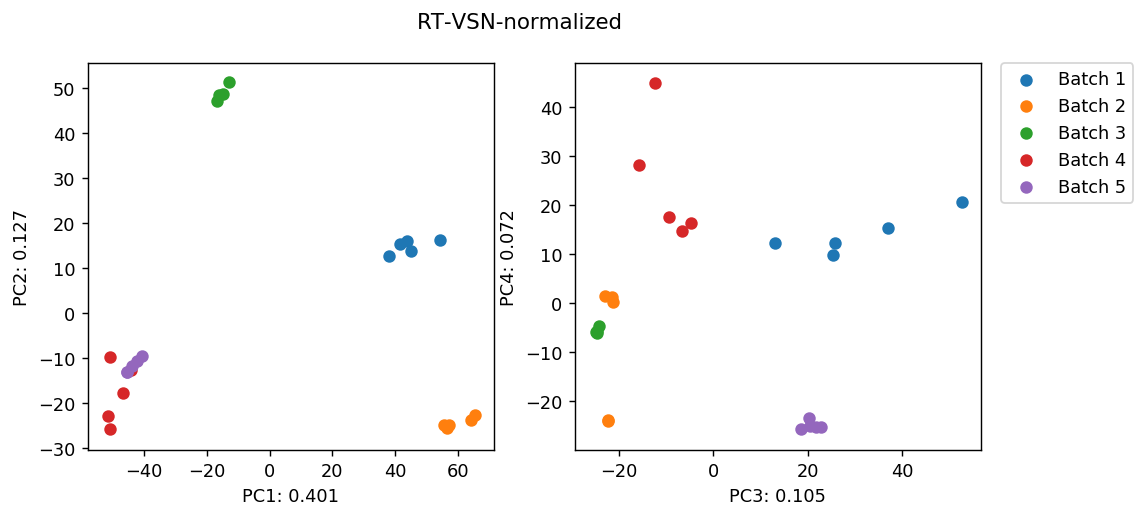

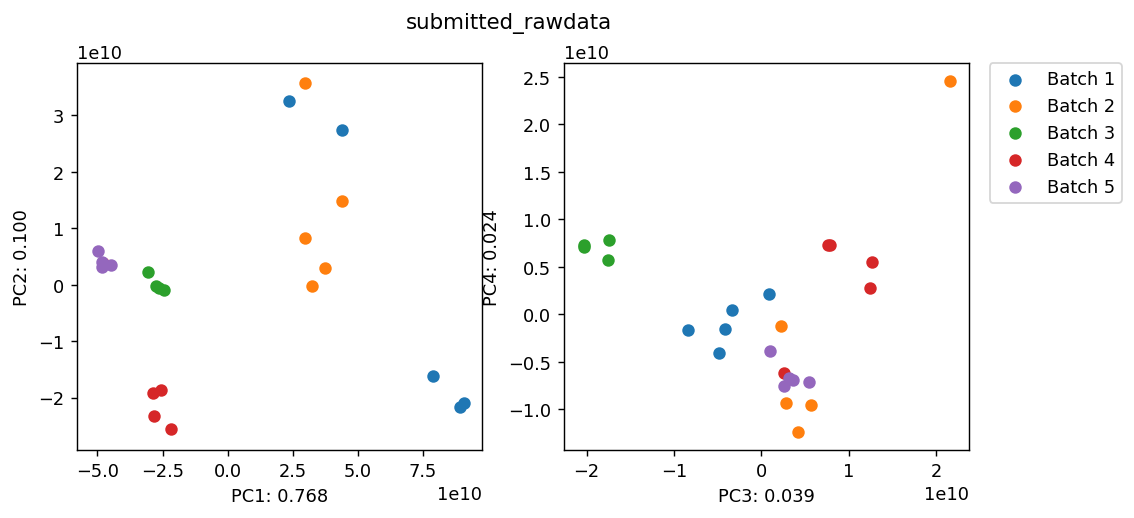

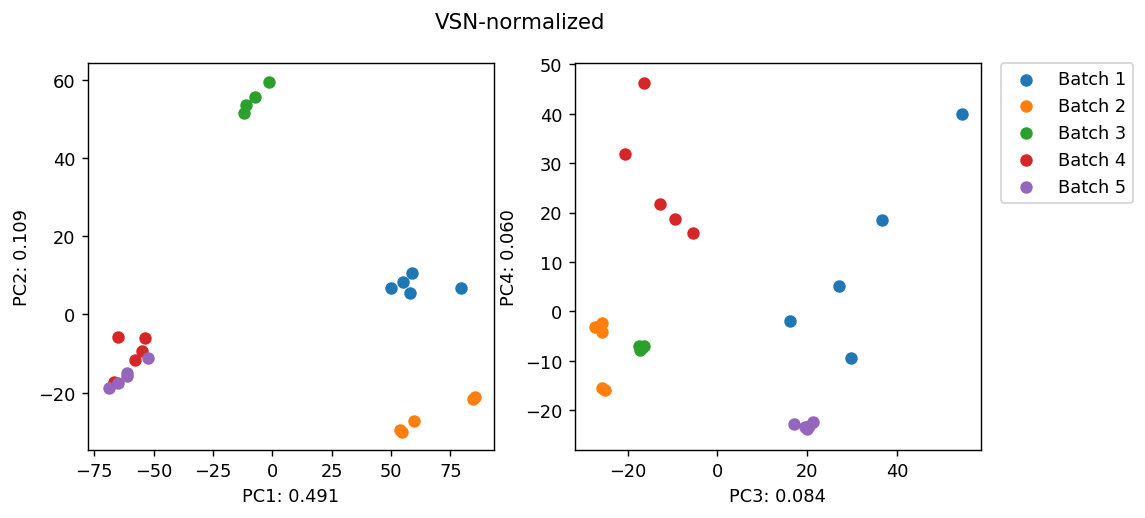

In [3]:
for f in os.listdir('../../data/original_data/hela/'):
    if f.endswith('txt'):
        data = '../../data/original_data/hela/'+f
        design = '../../data/original_data/hela_design.tsv'
        cx_lib.PCA_plot(dataFP=data, designFP=design, sample='sample', groupBy='group')

### Using RT-Loess-normalized for subsequent analysis, the statistical part is done by ```scripts/R/statistic.R```

In [4]:
hela_stats = pd.read_csv('../../data/original_data/hela/hela_stats.tsv', sep='\t')
hela_stats['Sequence'] = hela_stats.apply(lambda x: re.findall('[A-Z]*', x['Peptide.Sequence'])[0], axis=1)
hela_stats['Length'] = hela_stats.apply(lambda x: len(x['Sequence']), axis=1)

# 521
stable = hela_stats[np.logical_and(list(hela_stats['2-5_AdjPVal'] > 0.9), list(np.abs(hela_stats['2-5_log2FoldChange']) < 0.1))].dropna(how='any')
stable['Label'] = 1

#543
unstable = hela_stats[np.logical_and(list(hela_stats['2-5_AdjPVal'] < 0.01), list(np.abs(hela_stats['2-5_log2FoldChange']) > 2.1))].dropna(how='any')
unstable['Label'] = 0

hela_data = pd.concat([stable, unstable], axis=0)
# hela_data[['Sequence','Average.RT','Average.m.z','Length','Label']].to_csv('../../data/original_data/hela/hela_data.csv', index=False)

### Add features with ```scripts/R/peptides.R```

In [5]:
data_set = pd.read_csv('../../data/original_data/hela/hela_trainSet.csv').sample(frac=1).reset_index(drop=True)
features = ['Aliphatic', 'Istablity', 'Boman', 'Mass', 'Tiny', 'Small',
       'Alphatic-aa', 'Aromatic', 'NonPolar', 'Polar', 'Charged', 'Basic',
       'Acidic', 'Hydrophobicity', 'Alpha', 'Bulk', 'Compositional', 'Local flexibility', 
        'Electronic properties', 'Length','Average.RT', 'Average.m.z']
# cx_lib.feature_comparison(data_set, features, 5, 5)

## Preliminary feature selection

In [4]:
%%time
X ,y = data_set[features], data_set['Label']

lr_sel = RFE(estimator=LogisticRegression(max_iter = 10000), n_features_to_select=10, step=1)
lr_sel.fit_transform(X, y)
dt_sel = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10, step=1)
dt_sel.fit_transform(X, y)
sv_sel = RFE(estimator=SVC(kernel="linear"), n_features_to_select=10, step=1)
sv_sel.fit_transform(X, y)
lr_fea = X.columns[lr_sel.get_support()]
dt_fea = X.columns[dt_sel.get_support()]
sv_fea = X.columns[sv_sel.get_support()]

Wall time: 1min 13s


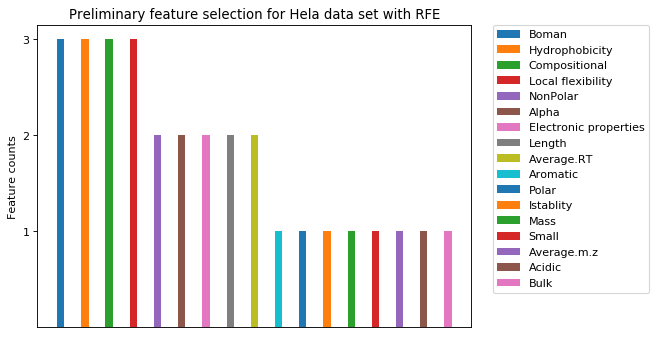

In [5]:
fea_stat = {}
for fea in [lr_fea, dt_fea, sv_fea]:
    for i in fea:
        fea_stat[i] = fea_stat.get(i, 0)+1
fea_stat = {k:v for k,v in sorted(fea_stat.items(), key=lambda d: d[1], reverse=True) }

plt.figure(dpi=80, figsize = (7,5))
for i, key in enumerate(fea_stat):
    plt.bar(i, fea_stat[key], width=0.3)
# plt.xticks(np.arange(len(fea_stat))-0.05, fea_stat.keys(), rotation=75)
plt.xticks([])
plt.yticks([1,2,3])
plt.legend(fea_stat.keys(),bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0)
plt.ylabel('Feature counts')
plt.title('Preliminary feature selection for Hela data set with RFE')
plt.show()

In [9]:
fea_stat.keys()

dict_keys(['Boman', 'Hydrophobicity', 'Compositional', 'Local flexibility', 'NonPolar', 'Alpha', 'Electronic properties', 'Length', 'Average.RT', 'Aromatic', 'Polar', 'Istablity', 'Mass', 'Small', 'Average.m.z', 'Acidic', 'Bulk'])

# Model Training 

## Logistic regression

In [63]:
%%time
lr_features = ['Boman', 'Hydrophobicity', 'Compositional',  'Length', 'Average.RT', 'Average.m.z']

X_train, X_test, y_train, y_test = train_test_split(data_set[lr_features], data_set['Label'], test_size=0.3, random_state=0)

def PolynomialLR(degree, C):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('std_scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C=C, max_iter=5000))
    ])

best_degree, best_C, best_score = 0, 0, 0
for d in range(1,4):
    for c in np.arange(0.1, 1.0, 0.1):
        poly_lr = PolynomialLR(degree=d, C=c)
        scores = cross_val_score(poly_lr, X_train, y_train)
        score = np.mean(scores)
        if score > best_score:
            best_degree, best_C, best_score = d, c, score
            
print("Best degree =", best_degree)
print("Best C =", best_C)
print("Best Score =", best_score)

Best degree = 3
Best C = 0.5
Best Score = 0.6371122800653002
Wall time: 2.13 s


In [64]:
best_lr_clf = PolynomialLR(degree=best_degree, C=best_C)
best_lr_clf.fit(X_train, y_train)
print(best_lr_clf.score(X_test, y_test))

lr_prob = best_lr_clf.predict_proba(X_test)[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)
lr_auc = auc(lr_fpr, lr_tpr)

0.615625


## Support Vector Machine

In [84]:
%%time
svc_features = ['Boman', 'Hydrophobicity',  'Length', 'Average.RT']
X_train, X_test, y_train, y_test = train_test_split(data_set[svc_features], data_set['Label'], test_size=0.3, random_state=0)


def PolynomialKernelSVC(degree, C, kernel):
    return Pipeline([
        ("std_scaler", StandardScaler()),
        ("kernelSVC", SVC(kernel=kernel, degree=degree, C=C, probability=True))
    ])

best_degree, best_C, best_score , best_kernel = 0, 0, 0, ''
for k in ['linear','poly', 'rbf', 'sigmoid']:
    for d in [1,2]:
        for c in [0.5, 1.0, 2.0, 5.0, 10.0]:
            poly_svc = PolynomialKernelSVC(degree=d, C=c, kernel=k)
            scores = cross_val_score(poly_svc, X_train, y_train)
            score = np.mean(scores)
            if score > best_score:
                best_degree, best_C, best_score, best_kernel = d, c, score, k
            
print("Best degree =", best_degree)
print("Best C =", best_C)
print("Best Kernel =", best_kernel)
print("Best Score =", best_score)

Best degree = 2
Best C = 2.0
Best Kernel = poly
Best Score = 0.6250589515690186
Wall time: 6.95 s


In [85]:
best_svc_clf = PolynomialKernelSVC(degree=best_degree, C=best_C, kernel=best_kernel)
best_svc_clf.fit(X_train, y_train)
print(best_svc_clf.score(X_test, y_test))

svc_prob = best_svc_clf.predict_proba(X_test)[:,1]
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_prob)
svc_auc = auc(svc_fpr, svc_tpr)

0.603125


## Random Forest Classifier 

In [134]:
%%time
rf_features = ['Boman', 'Hydrophobicity', 'Compositional', 'Local flexibility', 'NonPolar', 'Length', 'Average.RT']
X_train, X_test, y_train, y_test = train_test_split(data_set[rf_features], data_set['Label'], test_size=0.3)

best_score = 0
for n in range(100,1000,200):
    rf_clf = RandomForestClassifier(n_estimators=n, oob_score=True,  n_jobs=-1, random_state=0)
    scores = cross_val_score(rf_clf, X_train, y_train)
    score = np.mean(scores)
    if score > best_score:
        best_n, best_score= n, score

        
print("Best number of clf =", best_n)
print("Best Score =", best_score)   

Best number of clf = 900
Best Score = 0.5980409940141482
Wall time: 17.7 s


In [135]:
best_rf_clf = RandomForestClassifier(n_estimators=best_n, oob_score=True,  n_jobs=-1, random_state=0)
best_rf_clf.fit(X_train, y_train)
print(best_rf_clf.oob_score_)

rf_prob = best_rf_clf.predict_proba(X_test)[:,1]

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
rf_auc = auc(rf_fpr, rf_tpr)

0.6088709677419355


##  AdaBoost Classifier

In [158]:
%%time
ada_features = ['Boman', 'Hydrophobicity', 'Compositional',  'Length',  'Electronic properties']
X_train, X_test, y_train, y_test = train_test_split(data_set[ada_features], data_set['Label'], test_size=0.3, random_state=0)


best_depth, best_estimators, best_score = 0, 0, 0

for d in [1,2,3]:
    for e in range(100,600, 100):
        ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), n_estimators=e, random_state=0)
        scores = cross_val_score(ada_clf, X_train, y_train)
        score = np.mean(scores)
        if score > best_score:
            best_depth, best_estimators, best_score = d, e, score

print("Best depth =", best_depth)
print("Best Estimators =", best_estimators)
print("Best Score =", best_score)
X_train, X_test, y_train, y_test = train_test_split(data_set[ada_features], data_set['Label'], test_size=0.3, random_state=0)

Best depth = 1
Best Estimators = 100
Best Score = 0.5793760203156176
Wall time: 30.6 s


In [159]:
best_ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth), n_estimators=best_estimators, random_state=0)
best_ada_clf.fit(X_train, y_train)
score = best_ada_clf.score(X_test, y_test)
print(score)

feature_importances = pd.DataFrame(best_ada_clf.feature_importances_, columns = ['Importance'], index=ada_features)

ada_prob = best_ada_clf.predict_proba(X_test)[:,1]
ada_fpr, ada_tpr, _ = roc_curve(y_test, ada_prob)
ada_auc = auc(ada_fpr, ada_tpr)

0.553125


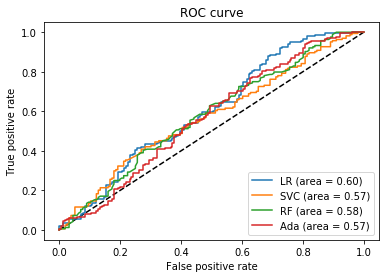

In [251]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_fpr, lr_tpr, label='LR (area = %0.2f)' % lr_auc)
plt.plot(svc_fpr, svc_tpr, label='SVC (area = %0.2f)' % svc_auc)
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_auc)
plt.plot(ada_fpr, ada_tpr, label='Ada (area = %0.2f)' % ada_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()